## **1 FC LAYER WITH SIGMOID ACTIVATION**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# Load the fashion MNIST dataset
train_dataset = FashionMNIST(root='.', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='.', download=True, train=False, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
device= 'cuda:0'

In [ ]:
# Define the denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), # kernel size 2 --> 3
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            #nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(256,10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x1 = x.view(x.size(0), -1)
        x1 = self.classifier(x1)
        x = self.decoder(x)
        return x,x1



In [ ]:
model = DenoisingAutoencoder()
model.to(device)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): ConvTranspose2d(32, 16, kernel_size=(5, 5), strid

In [ ]:
# Define the loss function and the optimizer
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Training and testing on 1 FC layer model
train_loss = []
train_acc = []
test_loss = []
test_acc =[]
noise_factor = 0.2
for epoch in range(20):
    model.train()
    correct = 0
    for data, label in train_loader:
        #print('images.shape:', data.shape)
        #print('label.shape:', label.shape)
        
        # Add noise to the data
        data_noisy = data + noise_factor * torch.randn(*data.shape)
        data_noisy = torch.clamp(data_noisy, 0, 1)
        data=data.float().to(device)
        label=label.long().to(device)
        label=torch.nn.functional.one_hot(label,num_classes=10)
        label=label.float()
        data_noisy=data_noisy.float().to(device)
        optimizer.zero_grad()
        # Forward pass
        output,label_out = model(data_noisy)
        #print(data_noisy.shape,output.shape)
        predicted = torch.argmax(label_out, 1)
        gt = torch.argmax(label, 1)
        #total += label.size(0)
        correct += (predicted == gt).sum().item()
        # Compute the loss
        loss1 = criterion1(output, data)
        loss2 = criterion2(label_out,label)
        tr_loss=loss1+loss2
        tr_loss.backward()
        optimizer.step()
    train_loss.append(tr_loss.item())
    tr_acc = correct/(len(train_loader)*128)
    train_acc.append(tr_acc)
    
    correct =0
    model.eval()
    for data, label in test_loader:
        data_noisy = data + noise_factor * torch.randn(*data.shape)
        data_noisy = torch.clamp(data_noisy, 0, 1)
        data=data.float().to(device)
        label=label.long().to(device)
        label=torch.nn.functional.one_hot(label,num_classes=10)
        label=label.float()
        data_noisy=data_noisy.float().to(device)
        output,label_out = model(data_noisy)
        predicted = torch.argmax(label_out, 1)
        gt = torch.argmax(label, 1)
        correct += (predicted == gt).sum().item()
        loss1 = criterion1(output, data)
        loss2 = criterion2(label_out,label)
        te_loss=loss1+loss2
    acc = correct/(len(test_loader)*128)
    test_loss.append(te_loss.item())
    test_acc.append(acc)
    print("Epoch: ", epoch, " Train_Loss: ", tr_loss.item() , " Test_Loss: ", te_loss.item(), " Train_acc: ", tr_acc*100, " Test_acc: ", acc*100)

Epoch:  0  Train_Loss:  0.13671796023845673  Test_Loss:  0.10939481854438782  Train_acc:  54.96235341151387  Test_acc:  74.01107594936708
Epoch:  1  Train_Loss:  0.10953143984079361  Test_Loss:  0.08564650267362595  Train_acc:  77.68523454157783  Test_acc:  77.86787974683544
Epoch:  2  Train_Loss:  0.09997901320457458  Test_Loss:  0.08661523461341858  Train_acc:  80.8702025586354  Test_acc:  80.10284810126582
Epoch:  3  Train_Loss:  0.11064982414245605  Test_Loss:  0.06783375144004822  Train_acc:  82.98740671641791  Test_acc:  81.74446202531645
Epoch:  4  Train_Loss:  0.10351205617189407  Test_Loss:  0.07859402894973755  Train_acc:  84.11847014925374  Test_acc:  82.73338607594937
Epoch:  5  Train_Loss:  0.08575126528739929  Test_Loss:  0.07791145890951157  Train_acc:  84.84641524520255  Test_acc:  83.07950949367088
Epoch:  6  Train_Loss:  0.08654549717903137  Test_Loss:  0.07633041590452194  Train_acc:  85.36447228144989  Test_acc:  83.46518987341773
Epoch:  7  Train_Loss:  0.068703398

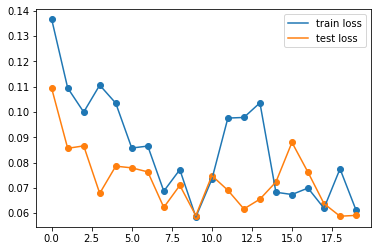

In [ ]:
k = [i for i in range(20)]
l = ['train loss','test loss']
plt.plot(k,train_loss,label=l[0])
plt.scatter(k,train_loss)
plt.plot(k,test_loss,label=l[1])
plt.scatter(k,test_loss)
plt.legend()
plt.show()

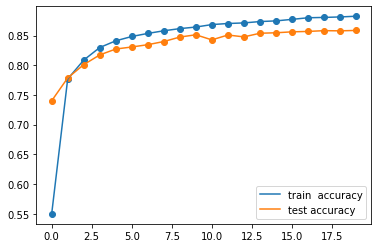

In [ ]:
k = [i for i in range(20)]
l = ['train  accuracy','test accuracy']
plt.plot(k,train_acc,label=l[0])
plt.scatter(k,train_acc)
plt.plot(k,test_acc,label=l[1])
plt.scatter(k,test_acc)
plt.legend()
plt.show()

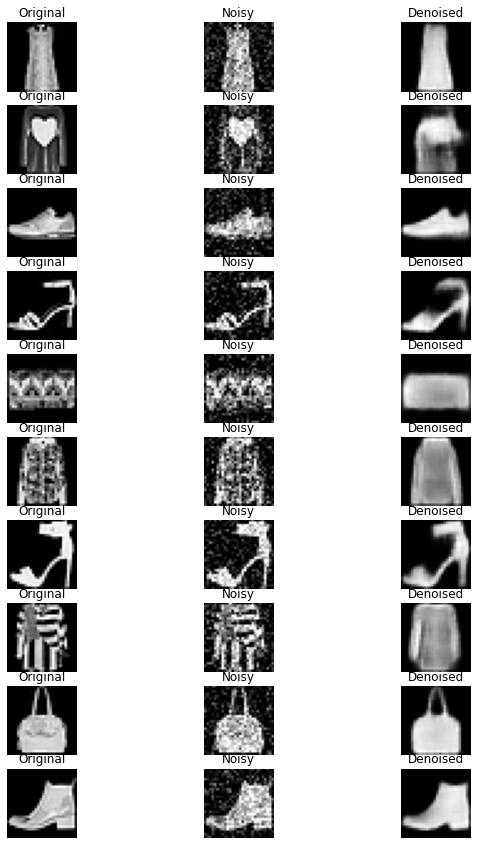

In [80]:
fig = plt.figure(figsize=(10,15))
for i in range(10):
  fig.add_subplot(10,3,i*3+1)
  plt.imshow(data[i].reshape(28,28).cpu().detach().numpy(), cmap='gist_gray')
  plt.axis('off')
  plt.title("Original")
  fig.add_subplot(10,3,i*3+2)
  plt.imshow(data_noisy[i].reshape(28,28).cpu().detach().numpy(), cmap='gist_gray')
  plt.axis('off')
  plt.title("Noisy")
  fig.add_subplot(10,3,i*3+3)
  plt.imshow(output[i].reshape(28,28).cpu().detach().numpy(), cmap='gist_gray')
  plt.axis('off')
  plt.title("Denoised")
plt.show()

# **3 FC LAYER WITH SIGMOID ACTIVATION**

In [ ]:
# Define the denoising autoencoder model with 3 FC layers
class DenoisingAutoencoder3FC(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder3FC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), # kernel size 2 --> 3
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            #nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x1 = x.view(x.size(0), -1)
        x1 = self.classifier(x1)
        x = self.decoder(x)
        return x,x1

In [ ]:
model3FC = DenoisingAutoencoder3FC()
model3FC.to(device)

DenoisingAutoencoder3FC(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): ConvTranspose2d(32, 16, kernel_size=(5, 5), st

In [ ]:
# Define the loss function and the optimizer
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()
optimizer3FC = optim.Adam(model3FC.parameters())

In [73]:
# Training and testing loop on 3FC layer model
train_loss3FC = []
train_acc3FC = []
test_loss3FC = []
test_acc3FC =[]
noise_factor = 0.2
for epoch in range(20):
    model3FC.train()
    correct = 0
    for data3FC, label3FC in train_loader:
        #print('images.shape:', data.shape)
        #print('label.shape:', label.shape)
        
        # Add noise to the data
        data_noisy3FC = data3FC + noise_factor * torch.randn(*data3FC.shape)
        data_noisy3FC = torch.clamp(data_noisy3FC, 0, 1)
        data3FC=data3FC.float().to(device)
        label3FC=label3FC.long().to(device)
        label3FC=torch.nn.functional.one_hot(label3FC,num_classes=10)
        label3FC=label3FC.float()
        data_noisy3FC=data_noisy3FC.float().to(device)
        optimizer3FC.zero_grad()
        # Forward pass
        output3FC,label_out3FC = model3FC(data_noisy3FC)
        #print(data_noisy.shape,output.shape)
        predicted3FC = torch.argmax(label_out3FC, 1)
        gt = torch.argmax(label3FC, 1)
        #total += label.size(0)
        correct += (predicted3FC == gt).sum().item()
        # Compute the loss
        loss1 = criterion1(output3FC, data3FC)
        loss2 = criterion2(label_out3FC,label3FC)
        tr_loss3FC=loss1+loss2
        tr_loss3FC.backward()
        optimizer3FC.step()
    train_loss3FC.append(tr_loss3FC.item())
    tr_acc3FC = correct/(len(train_loader)*128)
    train_acc3FC.append(tr_acc3FC)
    
    correct =0
    model3FC.eval()
    for data3FC, label3FC in test_loader:
        data_noisy3FC = data3FC + noise_factor * torch.randn(*data3FC.shape)
        data_noisy3FC = torch.clamp(data_noisy3FC, 0, 1)
        data3FC=data3FC.float().to(device)
        label3FC=label3FC.long().to(device)
        label3FC=torch.nn.functional.one_hot(label3FC,num_classes=10)
        label3FC=label3FC.float()
        data_noisy3FC=data_noisy3FC.float().to(device)
        output3FC,label_out3FC = model3FC(data_noisy3FC)
        predicted3FC = torch.argmax(label_out3FC, 1)
        gt = torch.argmax(label3FC, 1)
        correct += (predicted3FC == gt).sum().item()
        loss1 = criterion1(output3FC, data3FC)
        loss2 = criterion2(label_out3FC,label3FC)
        te_loss3FC=loss1+loss2
    acc3FC = correct/(len(test_loader)*128)
    test_loss3FC.append(te_loss3FC.item())
    test_acc3FC.append(acc)
    print("Epoch: ", epoch, " Train_Loss: ", tr_loss3FC.item() , " Test_Loss: ", te_loss3FC.item(), " Train_acc: ", tr_acc3FC*100, " Test_acc: ", acc3FC*100)

Epoch:  0  Train_Loss:  0.07512285560369492  Test_Loss:  0.06146416813135147  Train_acc:  89.50393123667378  Test_acc:  86.80775316455697
Epoch:  1  Train_Loss:  0.06731414794921875  Test_Loss:  0.05098329856991768  Train_acc:  89.57722547974414  Test_acc:  86.92642405063292
Epoch:  2  Train_Loss:  0.06038294732570648  Test_Loss:  0.04669703170657158  Train_acc:  89.80710287846482  Test_acc:  85.80893987341773
Epoch:  3  Train_Loss:  0.062050290405750275  Test_Loss:  0.0719577744603157  Train_acc:  89.84375  Test_acc:  86.50118670886076
Epoch:  4  Train_Loss:  0.06284734606742859  Test_Loss:  0.04141273722052574  Train_acc:  89.80210554371001  Test_acc:  86.81764240506328
Epoch:  5  Train_Loss:  0.07432258129119873  Test_Loss:  0.04729371517896652  Train_acc:  89.78544776119402  Test_acc:  87.18354430379746
Epoch:  6  Train_Loss:  0.05659962818026543  Test_Loss:  0.05891701579093933  Train_acc:  89.78544776119402  Test_acc:  87.18354430379746
Epoch:  7  Train_Loss:  0.06608033180236816

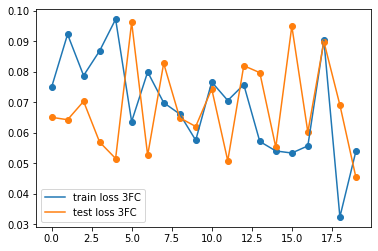

In [68]:
k = [i for i in range(20)]
l = ['train loss 3FC','test loss 3FC']
plt.plot(k,train_loss3FC,label=l[0])
plt.scatter(k,train_loss3FC)
plt.plot(k,test_loss3FC,label=l[1])
plt.scatter(k,test_loss3FC)
plt.legend()
plt.show()

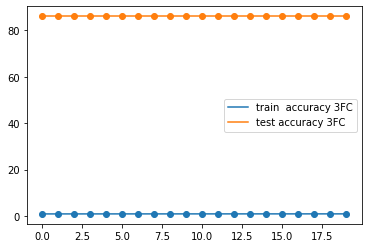

In [69]:
k = [i for i in range(20)]
l = ['train  accuracy 3FC','test accuracy 3FC']
plt.plot(k,train_acc3FC,label=l[0])
plt.scatter(k,train_acc3FC)
plt.plot(k,test_acc3FC,label=l[1])
plt.scatter(k,test_acc3FC)
plt.legend()
plt.show()

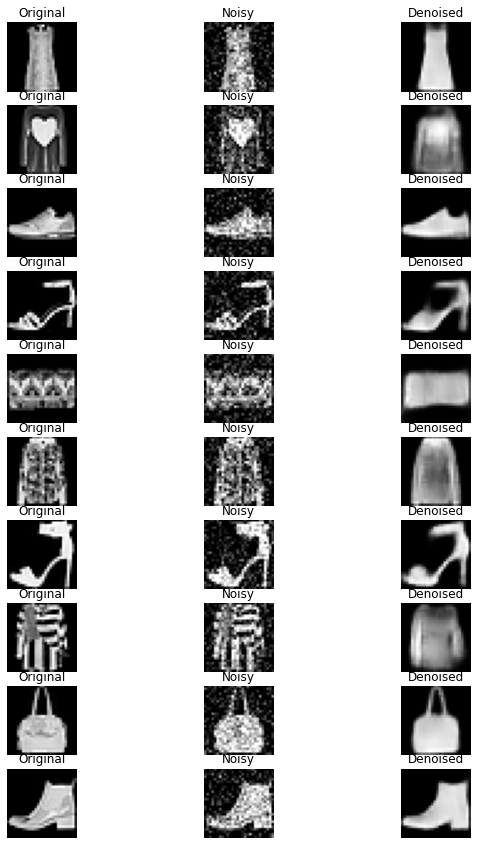

In [79]:
fig = plt.figure(figsize=(10,15))
for i in range(10):
  fig.add_subplot(10,3,i*3+1)
  plt.imshow(data3FC[i].reshape(28,28).cpu().detach().numpy(), cmap='gist_gray')
  plt.axis('off')
  plt.title("Original")
  fig.add_subplot(10,3,i*3+2)
  plt.imshow(data_noisy3FC[i].reshape(28,28).cpu().detach().numpy(), cmap='gist_gray')
  plt.axis('off')
  plt.title("Noisy")
  fig.add_subplot(10,3,i*3+3)
  plt.imshow(output3FC[i].reshape(28,28).cpu().detach().numpy(), cmap='gist_gray')
  plt.axis('off')
  plt.title("Denoised")
plt.show()

# **t-SNE PLOT FOR 1 FC LAYER MODEL**

In [109]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_loader:
    embed = model.encoder(img.to(device))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
embed_tensor = embed_tensor.reshape(1024,64*2*2)
label_tensor = torch.cat(lt_lb)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [110]:
lt_embed3FC = []
lt_lb3FC = []
ln3FC = 0 
with torch.no_grad():
  for img3FC, lb3FC in test_loader:
    embed3FC = model3FC.encoder(img3FC.to(device))
    lt_embed3FC.append(embed3FC.cpu())
    lt_lb3FC.append(lb3FC)
    ln3FC+=len(img3FC)
    if(ln3FC>=1000):
      break
embed_tensor3FC = torch.cat(lt_embed3FC)
embed_tensor3FC = embed_tensor3FC.reshape(1024,64*2*2)
label_tensor3FC = torch.cat(lt_lb3FC)
from sklearn.manifold import TSNE
tsne3FC = TSNE(n_components=2, random_state=0)
tsne_data3FC = tsne3FC.fit_transform(embed_tensor3FC)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


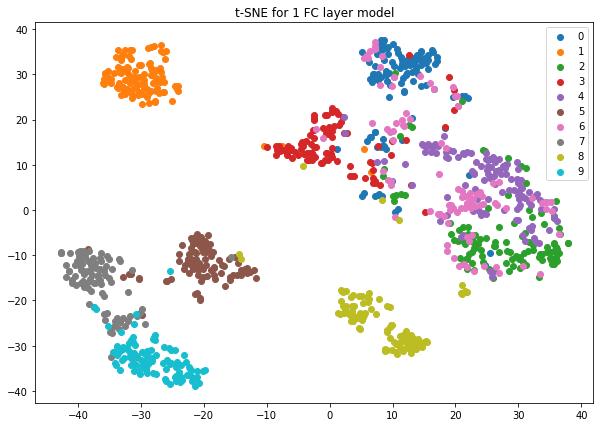

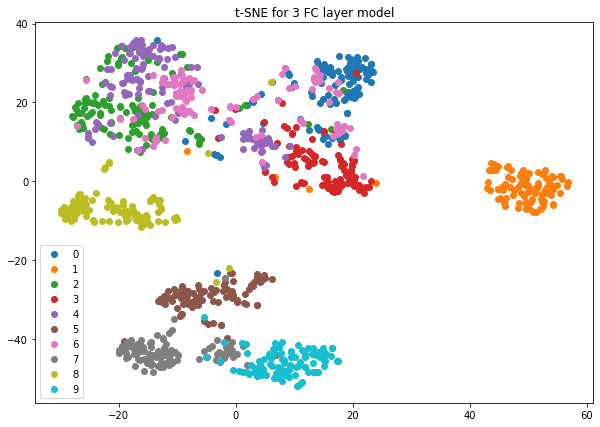

In [116]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(10, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.title('t-SNE for 1 FC layer model')
plt.show()

scatter_x3FC = tsne_data3FC[:,0]
scatter_y3FC = tsne_data3FC[:,1]
group3FC = label_tensor3FC

fig, ax = plt.subplots(figsize=(10, 7))
for g3FC in np.unique(group3FC):
    ix = np.where(group3FC == g3FC)
    ax.scatter(scatter_x3FC[ix], scatter_y3FC[ix],  label = g3FC)
ax.legend()
plt.title('t-SNE for 3 FC layer model')
plt.show()